In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imageio import imunread
from skimage.transform import resize
from sklearn import preprocessing, cross_validation, neighbors
import os
import tensorflow as tf
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [1]:
!pip3 install tqdm imageio

    100% |████████████████████████████████| 51kB 2.1MB/s 
    100% |████████████████████████████████| 3.3MB 7.6MB/s 


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
!ls

datalab  drive


In [0]:
os.chdir('drive')
os.chdir('FaceRec')

In [6]:
!ls

Ai class			images
backupv1.npy			labels.npy
Classroom Photos		labelsv1.npy
classroomPhotosEncodings.npy	labels_vgg_40.npy
classroomPhotosLabels.npy	mnist.ipynb
code				model
embs_hsv_v1.npy			test_image.jpg
embs.npy			transfer.h5
embs_vgg_40.npy			two_shot
facebook photos for clustering	vgg 40 people data
facenet.ipynb			vgg 40 results.ipynb
Facenet on vgg dataset.ipynb	vinay eyes open.JPG


In [17]:
!ls

drive


In [7]:
!pip install git+https://github.com/ipazc/mtcnn.git

  Cloning https://github.com/ipazc/mtcnn.git to /tmp/pip-req-build-uf1ovdri
  Running setup.py bdist_wheel for mtcnn ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-0j0thta1/wheels/ed/41/71/a9ae1b642532018974b4da9029f103ef47fa6892f098233755
Successfully built mtcnn


In [0]:
from mtcnn.mtcnn import MTCNN

In [9]:
detector = MTCNN()
model_path = '/content/drive/FaceRec/model/keras/model/facenet_keras.h5'
model = load_model(model_path)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def get_em(face):
    return calc_embs([face])
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y
def calc_embs(aligned_images, margin=10, batch_size=1):
    
    aligned_images = prewhiten(np.array(aligned_images))
            
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
def infer():
        vc = cv2.VideoCapture(0)
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
            plt.show()
            faces = cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            pred = None
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - margin // 2
                right = x + w + margin // 2
                bottom = y - margin // 2
                top = y + h + margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                embs = calc_embs(img[np.newaxis], margin, 1)
                pred = le.inverse_transform(clf.predict(embs))
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
            plt.imshow(frame)
            plt.title(pred)
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            try:
                plt.pause(0.1)
            except Exception:
                pass
            

In [0]:
infer()

0it [00:00, ?it/s]

Anmol Bhutada
/content/drive/FaceRec/tempImages/Anmol Bhutada/Anmol Bhutada37.jpg
(160, 160, 3)
/content/drive/FaceRec/tempImages/Anmol Bhutada/Anmol Bhutada29.jpg
(160, 160, 3)
/content/drive/FaceRec/tempImages/Anmol Bhutada/Anmol Bhutada13.jpg
(160, 160, 3)
/content/drive/FaceRec/tempImages/Anmol Bhutada/Anmol Bhutada0.jpg
(160, 160, 3)


1it [00:00,  1.07it/s]

Dhruv Parashar
/content/drive/FaceRec/tempImages/Dhruv Parashar/12066030_165142503833325_2911969118906492845_n.jpg
(960, 960, 3)
/content/drive/FaceRec/tempImages/Dhruv Parashar/11696581_233628660318042_5020212335287702294_o.jpg
(1536, 341, 3)
/content/drive/FaceRec/tempImages/Dhruv Parashar/31437445_1990256954381394_6393541467045888000_n.jpg
(619, 388, 3)
/content/drive/FaceRec/tempImages/Dhruv Parashar/15392949_10154141780308450_6741816411181765334_o.jpg


2it [00:02,  1.01s/it]

(1319, 266, 3)
Vinay Singh
/content/drive/FaceRec/tempImages/Vinay Singh/DSC_0021.JPG
(4000, 6000, 3)
/content/drive/FaceRec/tempImages/Vinay Singh/19800858_663797797152921_3451905945831211200_o.jpg
(1677, 1677, 3)
/content/drive/FaceRec/tempImages/Vinay Singh/19989458_663797800486254_7316223911829709051_n.jpg
(496, 128, 3)
/content/drive/FaceRec/tempImages/Vinay Singh/17021554_584644548401633_3027523422569653459_n.jpg


3it [00:30, 10.03s/it]

(581, 135, 3)


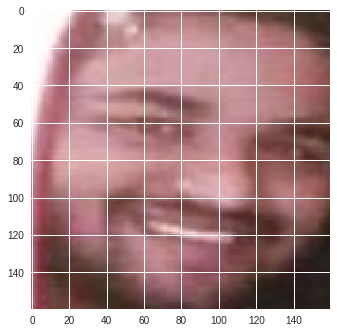

In [51]:
# dir_path=  '/content/drive/FaceRec/Classroom Photos/'
dir_path=  '/content/drive/FaceRec/tempImages/'

k=-1
ems = []
l = []
names = []
cropped=  []
for k,i in tqdm(enumerate(sorted(os.listdir(dir_path)))):
    print(i)
    if(i=='.DS_Store'):
        continue
    
    names.append(i)
    for o,j in enumerate(os.listdir(dir_path+i)):
        if(j=='.DS_Store'):
            continue
        im_path = dir_path+i+"/"+j
        print(im_path)
        im = cv2.imread(im_path)
        print(im.shape)
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        dets = detector.detect_faces(im)
        if(len(dets)==0):
          cropped = im
        else:
          face = dets[0]
          
          for z in range(2):
            if(face['box'][z]<0):
              face['box'][z] = 0
          [x,y,w,h] = face['box']  
          left = x
          right = x+w
          top = y
          bottom = y+h
          cropped = im[y:y+h,x:x+w]
          cropped = cv2.resize(cropped,(160,160))
        plt.imshow(cropped)
        #plt.show()
        em = get_em(cropped)
        ems.append(em)
        l.append(k)
#        np.save('/content/drive/FaceRec/facebook photos for clustering/'+str(k) + '_' + str(o),em)
#     np.save("/content/drive/FaceRec/classroomPhotosEncodings.npy",np.concatenate(ems))
#     np.save("/content/drive/FaceRec/classroomPhotosLabels.npy",np.array(l))

In [52]:
ems = np.concatenate(ems)
ems.shape

(12, 128)

In [53]:
l = np.array(l)
l.shape

(12,)

In [54]:
len(ems),l.shape

(12, (12,))

In [0]:
def trainKNearestNeighbours(embs,y):
    embs,y = unison_shuffled_copies(embs,y)
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(embs, y,test_size=0)
    print(X_test.shape)
    print(X_train.shape)
    clf = neighbors.KNeighborsClassifier(n_neighbors = 1,weights='distance')
    clf.fit(X_train, y_train)
  #  accuracy = clf.score(X_test, y_test)
  # print(accuracy)
    
    return clf

In [34]:
clf = trainKNearestNeighbours(ems,l)

(0, 128)
(10, 128)


In [0]:
from sklearn import svm
def trainSVM(embs,y):
  embs,y = unison_shuffled_copies(embs,y)
  X_train, X_test, y_train, y_test = cross_validation.train_test_split(embs, y,test_size=0.0)
  lin_clf = svm.LinearSVC()
  lin_clf.fit(X_train, y_train)
#   accuracy = clf.score(X_test, y_test)
#   print(accuracy)
  return lin_clf

In [0]:
clf = trainSVM(ems,l)

In [0]:
import xgboost as xgb
from sklearn.metrics import precision_score
def trainXGBoost(embs,y):
  embs,y = unison_shuffled_copies(embs,y)
  X_train, X_test, y_train, y_test = cross_validation.train_test_split(embs, y, test_size=0.2, random_state=42)
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test,label=y_test)
  param = {
    'max_depth': 1,  # the maximum depth of each tree
    'eta': 0.001,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 15}  # the number of classes that exist in this datset
  num_round =25000  # the number of training iterations
  bst = xgb.train(param, dtrain, num_round)
  preds = bst.predict(dtest)
  best_preds = np.asarray([np.argmax(line) for line in preds])
  print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))

In [93]:
trainXGBoost(ems,l)

Numpy array precision: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0


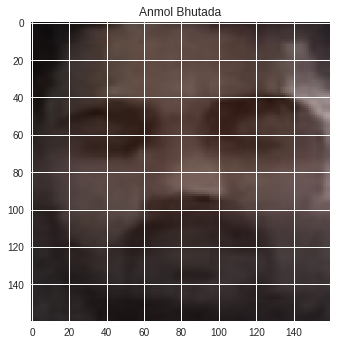

In [64]:
#img = cv2.imread('/content/drive/FaceRec/test_image.jpg')
#img = cv2.imread('/content/drive/FaceRec/vinay eyes open.jpg')
img = cv2.imread('/content/drive/FaceRec/vinay cropped/dummy.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dets = detector.detect_faces(img)

for face in dets:
    for i,f in enumerate(face['box']):
        if(f<0):
            face['box'][i] = 0
            

    [x,y,w,h] = face['box']
    left = x
    right = x+w
    top = y
    bottom = y+h
    cropped = img[y:y+h,x:x+w]
    cropped = cv2.resize(cropped,(160,160))
    pred = int (clf.predict(get_em(cropped))[0])
    print(pred)
    
    plt.title(names[pred])
    plt.imshow(cropped)
    plt.show()
    

In [0]:
def train(algo = 'kNN'):
  dir_path=  '/content/drive/FaceRec/Classroom Photos/'
  k=-1
  ems = []
  l = []
  names = []
  for k,i in tqdm(enumerate(sorted(os.listdir(dir_path)))):
      print(i)
      if(i=='.DS_Store'):
          continue

      names.append(i)
      for o,j in enumerate(os.listdir(dir_path+i)):
          if(j=='.DS_Store'):
              continue
          im_path = dir_path+i+"/"+j
#           print(im_path)
          im = cv2.imread(im_path)
#           print(im.shape)
          im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          dets = detector.detect_faces(im)
          if(len(dets)==0):
            cropped = im
          else:
            face = dets[0]

            for z in range(2):
              if(face['box'][z]<0):
                face['box'][z] = 0
            [x,y,w,h] = face['box']  
            left = x
            right = x+w
            top = y
            bottom = y+h
            cropped = im[y:y+h,x:x+w]
            cropped = cv2.resize(cropped,(160,160))
          plt.imshow(cropped)
          #plt.show()
          em = get_em(cropped)
          ems.append(em)
          l.append(k)
  ems=  np.concatenate(ems)
  l = np.array(l)
  if(algo=='kNN'):
    clf=trainKNearestNeighbours(ems,l)
    return clf,names
  else:
    clf=trainSVM(ems,l)
    return clf,names
  

['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Prateek Jha', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


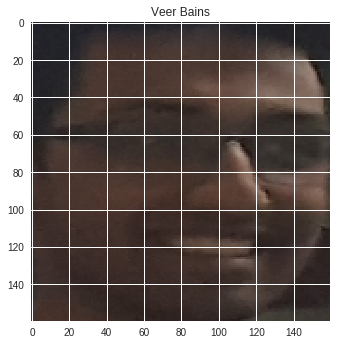

0 or 1 or 2   1
3
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Prateek Jha', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


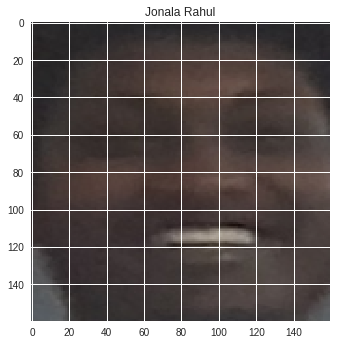

0 or 1 or 2   1
3
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Prateek Jha', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


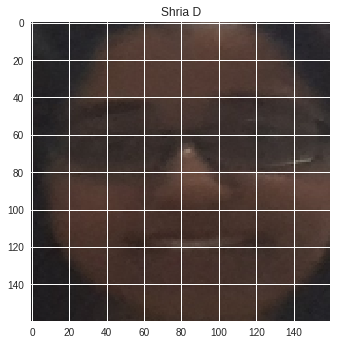

0 or 1 or 2   1
3
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Prateek Jha', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


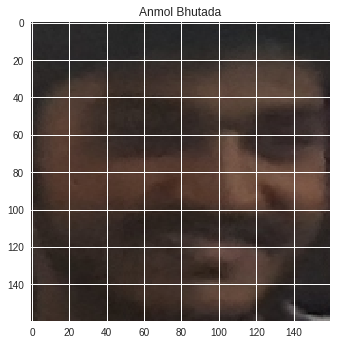

0 or 1 or 2   1
3
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Prateek Jha', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


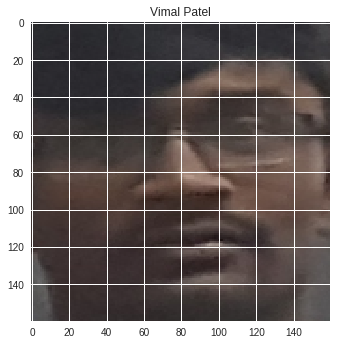

0 or 1 or 2   0
Who is it?   Revanth Pendyala


0it [00:00, ?it/s]

Akshay Raut


1it [00:00,  4.43it/s]

Ananya Anand


2it [00:01,  1.58it/s]

Anmol Bhutada


3it [00:01,  1.53it/s]

Chaitanya Chawla


4it [00:04,  1.00s/it]

Chaitanya Sai


5it [00:05,  1.01s/it]

Dhruv Parashar


6it [00:06,  1.03s/it]

Ganesh Singh


7it [00:06,  1.06it/s]

Harshit Buddhraja


8it [00:07,  1.06it/s]

Jonala Rahul


9it [00:08,  1.12it/s]

Kartik Mehta


10it [00:09,  1.09it/s]

Kundan Dewangan


11it [00:09,  1.13it/s]

Manish V


12it [00:09,  1.21it/s]

Prateek Jha


13it [00:10,  1.26it/s]

Revanth Pendyala


14it [00:10,  1.29it/s]

Sai Thapan


15it [00:11,  1.29it/s]

Sanjay Reddy


16it [00:13,  1.23it/s]

Saurabh Yadav


17it [00:14,  1.16it/s]

Sheldon D Souza


18it [00:14,  1.20it/s]

Shiksha Swaraj


19it [00:15,  1.25it/s]

Shria D


20it [00:15,  1.27it/s]

Simran Tiwari


21it [00:16,  1.27it/s]

Sudarshan Raghavan


22it [00:17,  1.24it/s]

Taniya Mangwani


23it [00:18,  1.23it/s]

Uddalak Bhaduri


24it [00:19,  1.25it/s]

Ujjwal Karna


25it [00:24,  1.03it/s]

Veer Bains


26it [00:24,  1.05it/s]

Viharika Reddie


27it [00:25,  1.05it/s]

Vimal Patel


28it [00:26,  1.04it/s]

Vinay Singh


29it [00:32,  1.12s/it]

Vivek Singh


30it [00:35,  1.17s/it]


['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


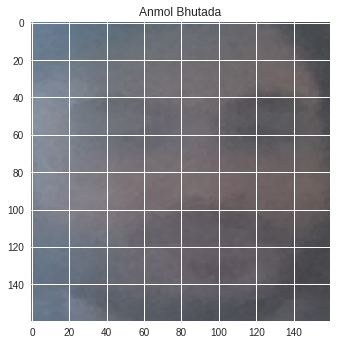

0 or 1 or 2   2
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


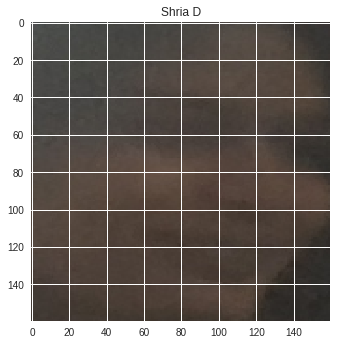

0 or 1 or 2   0
Who is it?   Manisha Baheti


0it [00:00, ?it/s]

Akshay Raut
Ananya Anand


2it [00:01,  1.54it/s]

Anmol Bhutada


3it [00:01,  1.68it/s]

Chaitanya Chawla


4it [00:03,  1.28it/s]

Chaitanya Sai


5it [00:03,  1.33it/s]

Dhruv Parashar


7it [00:04,  1.52it/s]

Ganesh Singh
Harshit Buddhraja


8it [00:05,  1.56it/s]

Jonala Rahul


9it [00:05,  1.60it/s]

Kartik Mehta


11it [00:06,  1.69it/s]

Kundan Dewangan
Manish V
Manisha Baheti


14it [00:07,  1.99it/s]

Prateek Jha
Revanth Pendyala


15it [00:07,  1.93it/s]

Sai Thapan
Sanjay Reddy


17it [00:08,  1.93it/s]

Saurabh Yadav


18it [00:10,  1.80it/s]

Sheldon D Souza
Shiksha Swaraj
Shria D


21it [00:11,  1.90it/s]

Simran Tiwari


22it [00:11,  1.91it/s]

Sudarshan Raghavan


23it [00:12,  1.88it/s]

Taniya Mangwani


25it [00:12,  1.93it/s]

Uddalak Bhaduri
Ujjwal Karna


26it [00:17,  1.49it/s]

Veer Bains


27it [00:17,  1.51it/s]

Viharika Reddie


28it [00:18,  1.52it/s]

Vimal Patel


29it [00:19,  1.51it/s]

Vinay Singh


30it [00:23,  1.25it/s]

Vivek Singh


31it [00:25,  1.21it/s]


['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


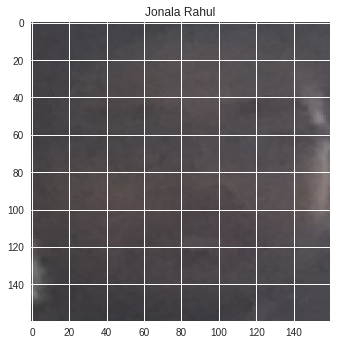

0 or 1 or 2   2
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


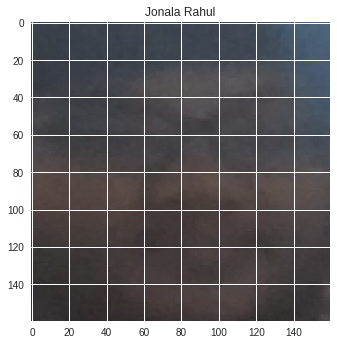

0 or 1 or 2   0
Who is it?   Manish V


0it [00:00, ?it/s]

Akshay Raut
Ananya Anand


2it [00:00,  2.72it/s]

Anmol Bhutada


3it [00:00,  3.21it/s]

Chaitanya Chawla


4it [00:02,  1.73it/s]

Chaitanya Sai


5it [00:02,  1.68it/s]

Dhruv Parashar


7it [00:03,  1.82it/s]

Ganesh Singh
Harshit Buddhraja


9it [00:04,  1.96it/s]

Jonala Rahul
Kartik Mehta


11it [00:05,  2.01it/s]

Kundan Dewangan
Manish V
Manisha Baheti


14it [00:05,  2.43it/s]

Prateek Jha
Revanth Pendyala


15it [00:05,  2.55it/s]

Sai Thapan
Sanjay Reddy


17it [00:06,  2.46it/s]

Saurabh Yadav


18it [00:08,  2.20it/s]

Sheldon D Souza
Shiksha Swaraj
Shria D


21it [00:08,  2.51it/s]

Simran Tiwari


22it [00:08,  2.49it/s]

Sudarshan Raghavan


23it [00:09,  2.40it/s]

Taniya Mangwani


25it [00:10,  2.43it/s]

Uddalak Bhaduri
Ujjwal Karna


26it [00:15,  1.67it/s]

Veer Bains


27it [00:15,  1.71it/s]

Viharika Reddie


28it [00:16,  1.71it/s]

Vimal Patel


29it [00:17,  1.70it/s]

Vinay Singh


30it [00:21,  1.37it/s]

Vivek Singh


31it [00:23,  1.32it/s]


['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


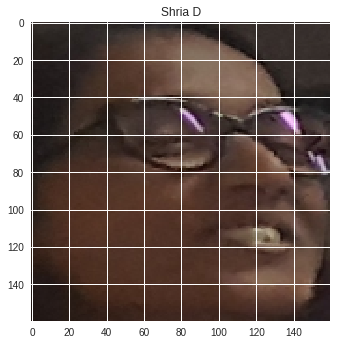

0 or 1 or 2   0
Who is it?   Shiksha Swaraj


0it [00:00, ?it/s]

Akshay Raut
Ananya Anand


3it [00:00,  3.23it/s]

Anmol Bhutada
Chaitanya Chawla


4it [00:02,  1.71it/s]

Chaitanya Sai


5it [00:03,  1.65it/s]

Dhruv Parashar


7it [00:03,  1.78it/s]

Ganesh Singh
Harshit Buddhraja


8it [00:04,  1.78it/s]

Jonala Rahul


9it [00:04,  1.92it/s]

Kartik Mehta


11it [00:05,  1.97it/s]

Kundan Dewangan
Manish V


12it [00:05,  2.02it/s]

Manisha Baheti


14it [00:06,  2.19it/s]

Prateek Jha
Revanth Pendyala


16it [00:06,  2.42it/s]

Sai Thapan
Sanjay Reddy


17it [00:07,  2.24it/s]

Saurabh Yadav


20it [00:08,  2.23it/s]

Sheldon D Souza
Shiksha Swaraj
Shria D


21it [00:09,  2.29it/s]

Simran Tiwari


22it [00:09,  2.28it/s]

Sudarshan Raghavan


23it [00:10,  2.21it/s]

Taniya Mangwani


25it [00:11,  2.25it/s]

Uddalak Bhaduri
Ujjwal Karna


27it [00:15,  1.70it/s]

Veer Bains
Viharika Reddie


28it [00:16,  1.71it/s]

Vimal Patel


29it [00:17,  1.69it/s]

Vinay Singh


30it [00:21,  1.36it/s]

Vivek Singh


31it [00:23,  1.32it/s]


['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


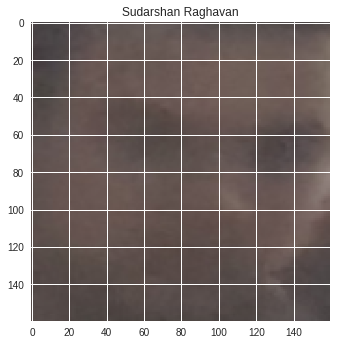

0 or 1 or 2   2
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


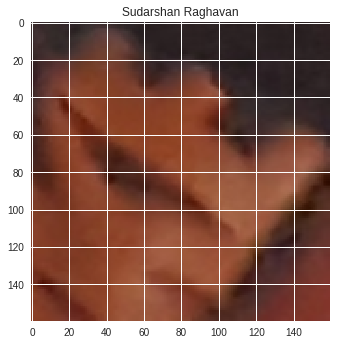

0 or 1 or 2   2
['Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


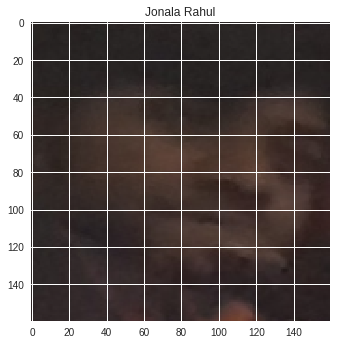

0 or 1 or 2   0
Who is it?   Akash Katragadda


1it [00:00,  6.13it/s]

Akash Katragadda
Akshay Raut
Ananya Anand


3it [00:00,  3.34it/s]

Anmol Bhutada


4it [00:01,  3.59it/s]

Chaitanya Chawla


5it [00:02,  1.92it/s]

Chaitanya Sai


6it [00:03,  1.81it/s]

Dhruv Parashar


8it [00:04,  1.90it/s]

Ganesh Singh
Harshit Buddhraja


9it [00:04,  1.89it/s]

Jonala Rahul


10it [00:04,  2.01it/s]

Kartik Mehta


12it [00:05,  2.04it/s]

Kundan Dewangan
Manish V


13it [00:05,  2.17it/s]

Manisha Baheti
Prateek Jha


16it [00:06,  2.54it/s]

Revanth Pendyala
Sai Thapan


17it [00:06,  2.66it/s]

Sanjay Reddy


18it [00:07,  2.43it/s]

Saurabh Yadav


19it [00:08,  2.19it/s]

Sheldon D Souza
Shiksha Swaraj


21it [00:09,  2.25it/s]

Shria D


22it [00:09,  2.30it/s]

Simran Tiwari


23it [00:10,  2.29it/s]

Sudarshan Raghavan


24it [00:10,  2.22it/s]

Taniya Mangwani


26it [00:11,  2.25it/s]

Uddalak Bhaduri
Ujjwal Karna


28it [00:16,  1.71it/s]

Veer Bains
Viharika Reddie


29it [00:16,  1.72it/s]

Vimal Patel


30it [00:17,  1.70it/s]

Vinay Singh


31it [00:22,  1.37it/s]

Vivek Singh


32it [00:24,  1.32it/s]


['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


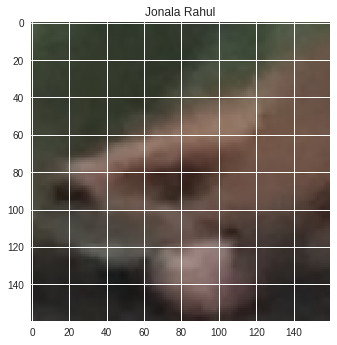

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


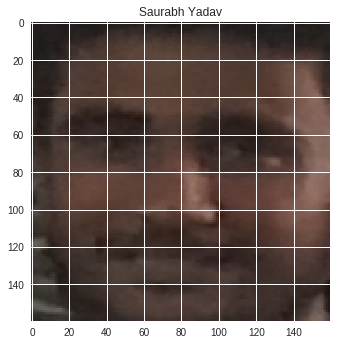

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


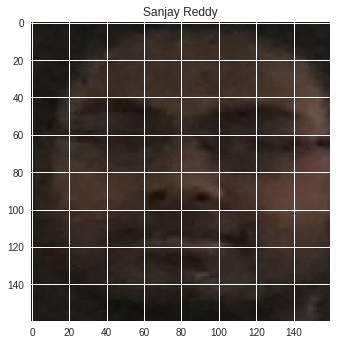

0 or 1 or 2   0
Who is it?   Kundan Dewangan


0it [00:00, ?it/s]

Akash Katragadda


1it [00:00,  1.75it/s]

Akshay Raut
Ananya Anand


4it [00:01,  2.76it/s]

Anmol Bhutada
Chaitanya Chawla


5it [00:02,  1.74it/s]

Chaitanya Sai


6it [00:03,  1.69it/s]

Dhruv Parashar


8it [00:04,  1.80it/s]

Ganesh Singh
Harshit Buddhraja


10it [00:05,  1.94it/s]

Jonala Rahul
Kartik Mehta


11it [00:05,  1.84it/s]

Kundan Dewangan


14it [00:06,  2.20it/s]

Manish V
Manisha Baheti
Prateek Jha


16it [00:06,  2.43it/s]

Revanth Pendyala
Sai Thapan


17it [00:06,  2.54it/s]

Sanjay Reddy


18it [00:07,  2.34it/s]

Saurabh Yadav


21it [00:09,  2.22it/s]

Sheldon D Souza
Shiksha Swaraj
Shria D


22it [00:09,  2.27it/s]

Simran Tiwari


23it [00:10,  2.26it/s]

Sudarshan Raghavan


24it [00:10,  2.19it/s]

Taniya Mangwani


26it [00:11,  2.23it/s]

Uddalak Bhaduri
Ujjwal Karna


27it [00:16,  1.66it/s]

Veer Bains


28it [00:16,  1.70it/s]

Viharika Reddie


29it [00:17,  1.70it/s]

Vimal Patel


30it [00:17,  1.68it/s]

Vinay Singh


31it [00:22,  1.36it/s]

Vivek Singh


32it [00:24,  1.32it/s]


['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


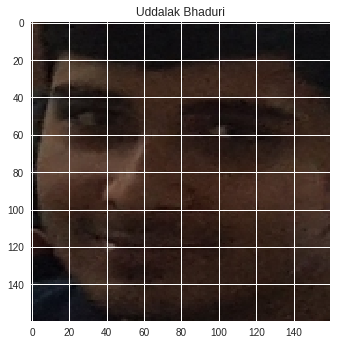

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


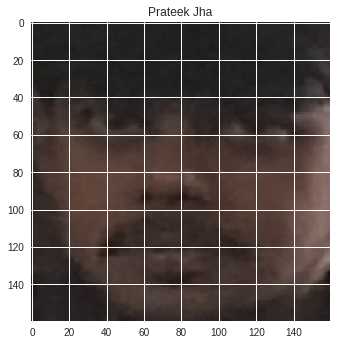

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


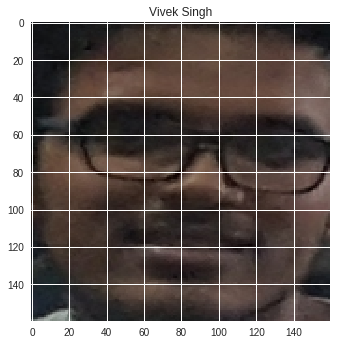

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


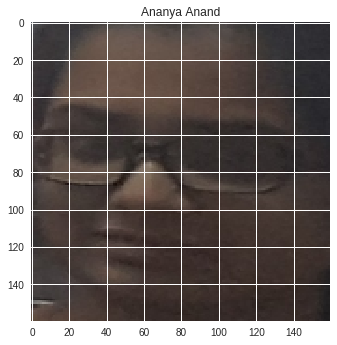

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


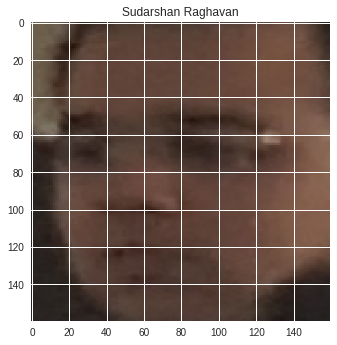

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


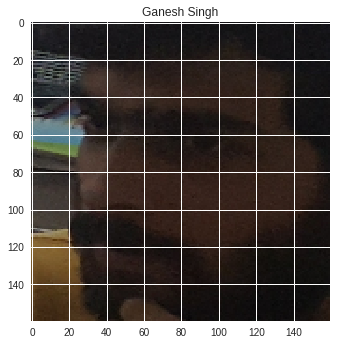

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


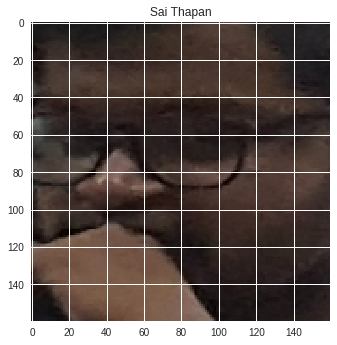

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


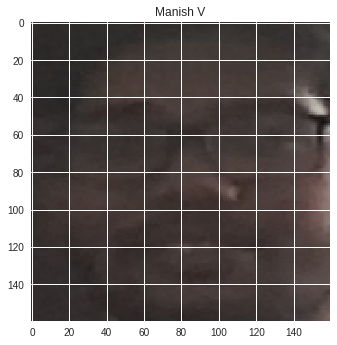

0 or 1 or 2   0
Who is it?   Sheldon D Souza


1it [00:00,  6.76it/s]

Akash Katragadda
Akshay Raut
Ananya Anand


4it [00:01,  2.86it/s]

Anmol Bhutada
Chaitanya Chawla


5it [00:02,  1.83it/s]

Chaitanya Sai


6it [00:03,  1.76it/s]

Dhruv Parashar


7it [00:04,  1.68it/s]

Ganesh Singh


8it [00:04,  1.67it/s]

Harshit Buddhraja


10it [00:05,  1.81it/s]

Jonala Rahul
Kartik Mehta


11it [00:06,  1.75it/s]

Kundan Dewangan


14it [00:06,  2.01it/s]

Manish V
Manisha Baheti
Prateek Jha


15it [00:07,  2.02it/s]

Revanth Pendyala
Sai Thapan


17it [00:08,  2.00it/s]

Sanjay Reddy


18it [00:09,  1.90it/s]

Saurabh Yadav


21it [00:10,  1.91it/s]

Sheldon D Souza
Shiksha Swaraj
Shria D


22it [00:11,  1.97it/s]

Simran Tiwari


23it [00:11,  1.97it/s]

Sudarshan Raghavan


24it [00:12,  1.88it/s]

Taniya Mangwani


25it [00:13,  1.87it/s]

Uddalak Bhaduri


26it [00:14,  1.82it/s]

Ujjwal Karna


28it [00:18,  1.48it/s]

Veer Bains
Viharika Reddie


29it [00:19,  1.49it/s]

Vimal Patel


30it [00:20,  1.48it/s]

Vinay Singh


31it [00:25,  1.23it/s]

Vivek Singh


32it [00:27,  1.17it/s]


['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


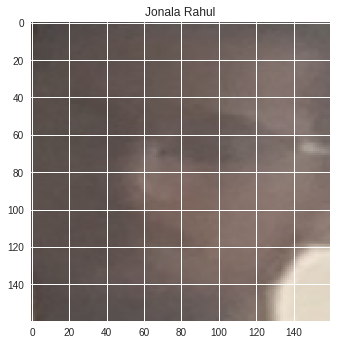

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


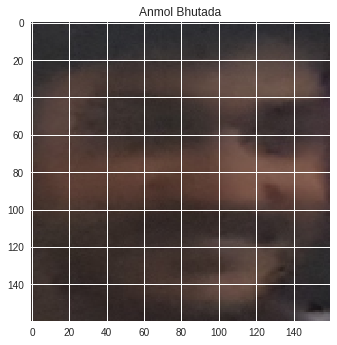

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


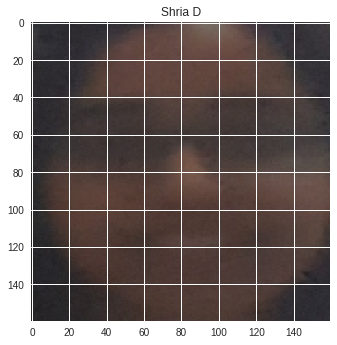

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


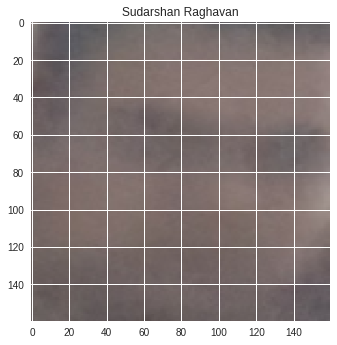

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


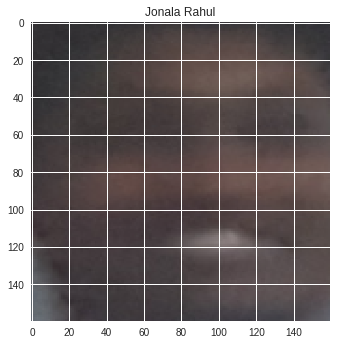

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


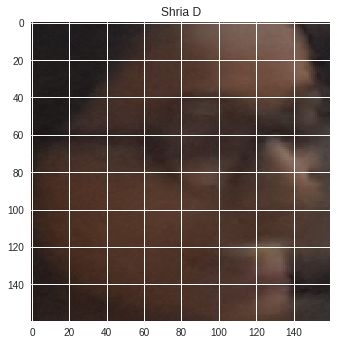

0 or 1 or 2   0
Who is it?   Shiksha Swaraj


1it [00:00,  6.94it/s]

Akash Katragadda
Akshay Raut
Ananya Anand


3it [00:00,  3.26it/s]

Anmol Bhutada


4it [00:01,  2.66it/s]

Chaitanya Chawla


5it [00:02,  1.71it/s]

Chaitanya Sai


6it [00:03,  1.66it/s]

Dhruv Parashar


8it [00:04,  1.75it/s]

Ganesh Singh
Harshit Buddhraja


10it [00:05,  1.88it/s]

Jonala Rahul
Kartik Mehta


12it [00:06,  1.91it/s]

Kundan Dewangan
Manish V


14it [00:06,  2.16it/s]

Manisha Baheti
Prateek Jha


16it [00:06,  2.36it/s]

Revanth Pendyala
Sai Thapan


17it [00:06,  2.44it/s]

Sanjay Reddy


18it [00:07,  2.27it/s]

Saurabh Yadav


19it [00:09,  2.05it/s]

Sheldon D Souza


20it [00:09,  2.06it/s]

Shiksha Swaraj


21it [00:09,  2.12it/s]

Shria D


22it [00:10,  2.10it/s]

Simran Tiwari


23it [00:10,  2.10it/s]

Sudarshan Raghavan


24it [00:11,  2.04it/s]

Taniya Mangwani


25it [00:12,  2.02it/s]

Uddalak Bhaduri


26it [00:12,  2.07it/s]

Ujjwal Karna


28it [00:17,  1.62it/s]

Veer Bains
Viharika Reddie


29it [00:17,  1.63it/s]

Vimal Patel


30it [00:18,  1.62it/s]

Vinay Singh


31it [00:23,  1.33it/s]

Vivek Singh


32it [00:24,  1.28it/s]


['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


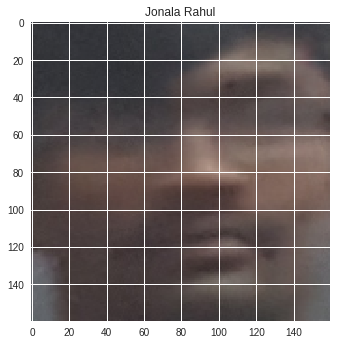

0 or 1 or 2   0
Who is it?   Revanth Pendyala


1it [00:00,  6.95it/s]

Akash Katragadda
Akshay Raut
Ananya Anand


3it [00:00,  3.23it/s]

Anmol Bhutada


4it [00:01,  3.31it/s]

Chaitanya Chawla


5it [00:02,  1.90it/s]

Chaitanya Sai


6it [00:03,  1.81it/s]

Dhruv Parashar


7it [00:04,  1.72it/s]

Ganesh Singh


8it [00:04,  1.87it/s]

Harshit Buddhraja


10it [00:05,  2.00it/s]

Jonala Rahul
Kartik Mehta


12it [00:05,  2.01it/s]

Kundan Dewangan


14it [00:06,  2.27it/s]

Manish V
Manisha Baheti
Prateek Jha


16it [00:06,  2.44it/s]

Revanth Pendyala
Sai Thapan


17it [00:06,  2.52it/s]

Sanjay Reddy


18it [00:07,  2.33it/s]

Saurabh Yadav


19it [00:09,  2.10it/s]

Sheldon D Souza
Shiksha Swaraj


21it [00:09,  2.11it/s]

Shria D


22it [00:10,  2.15it/s]

Simran Tiwari


23it [00:10,  2.15it/s]

Sudarshan Raghavan


24it [00:11,  2.08it/s]

Taniya Mangwani


25it [00:12,  2.06it/s]

Uddalak Bhaduri


26it [00:12,  2.10it/s]

Ujjwal Karna


28it [00:17,  1.63it/s]

Veer Bains
Viharika Reddie


29it [00:17,  1.64it/s]

Vimal Patel


30it [00:18,  1.63it/s]

Vinay Singh


31it [00:23,  1.33it/s]

Vivek Singh


32it [00:24,  1.29it/s]


['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


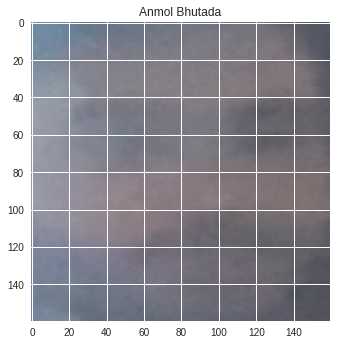

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


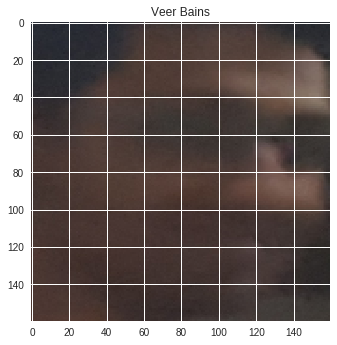

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


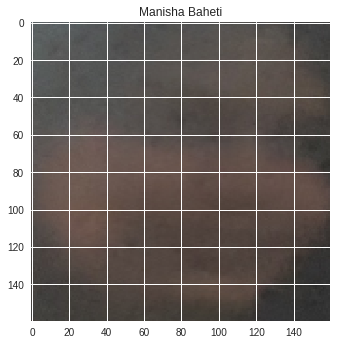

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


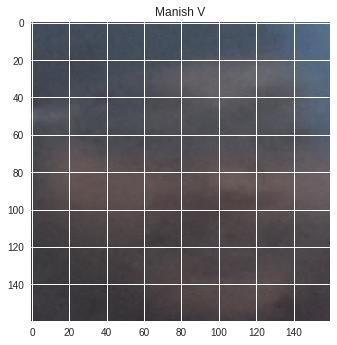

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


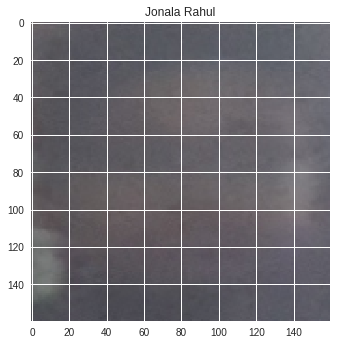

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


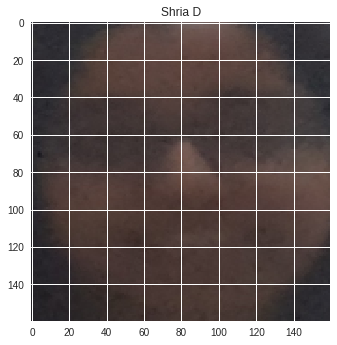

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


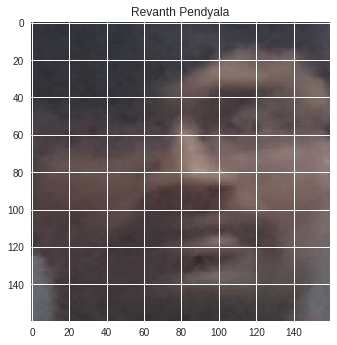

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


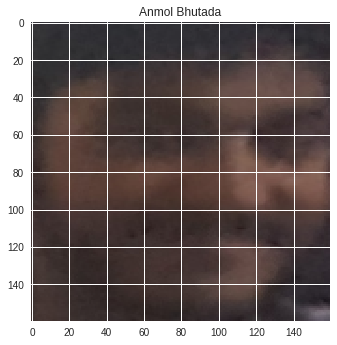

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


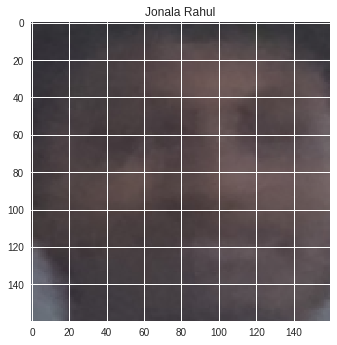

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


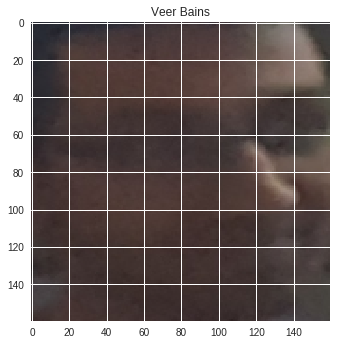

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


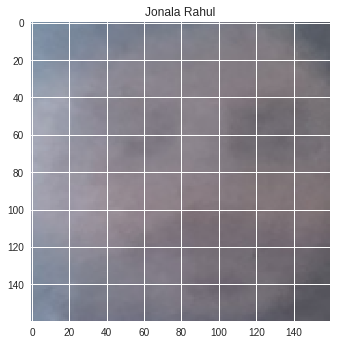

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


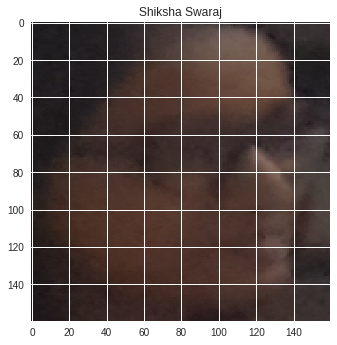

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


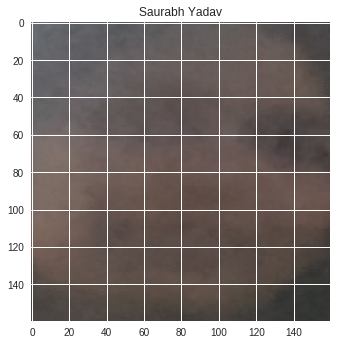

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


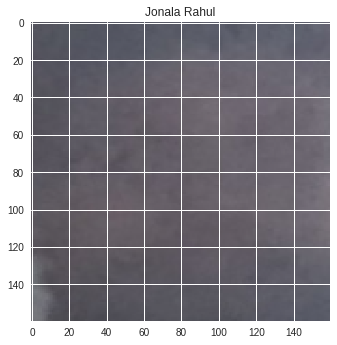

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


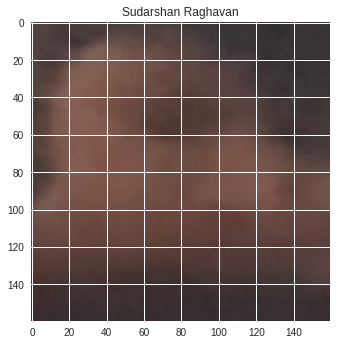

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


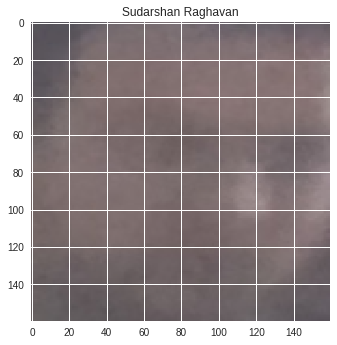

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


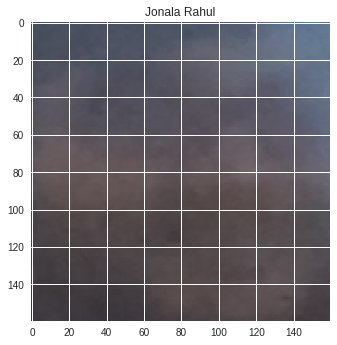

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


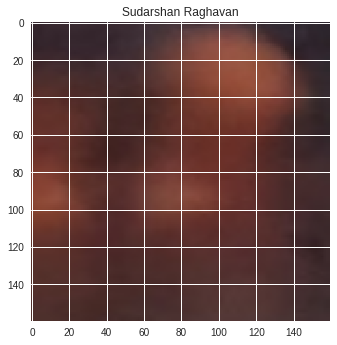

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


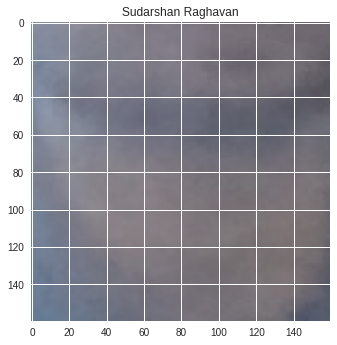

0 or 1 or 2   2
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


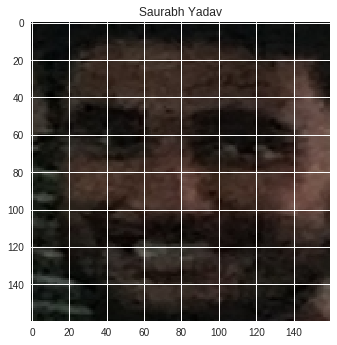

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


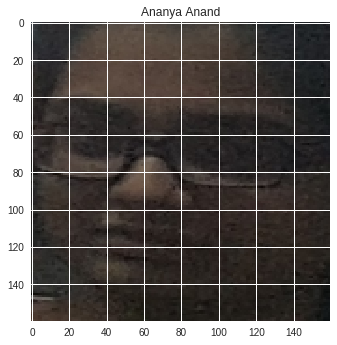

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


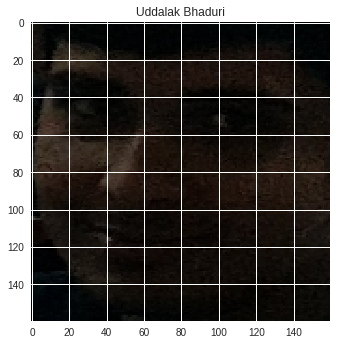

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


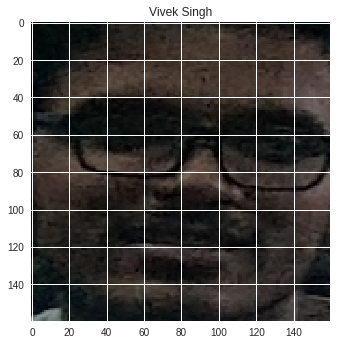

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


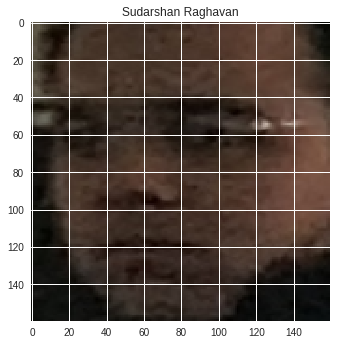

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


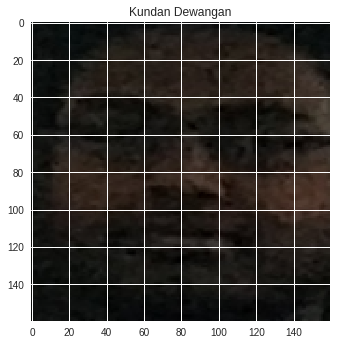

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


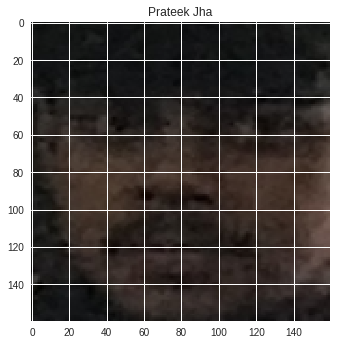

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


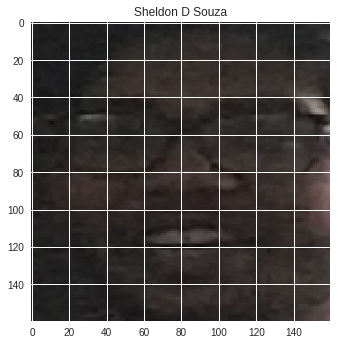

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


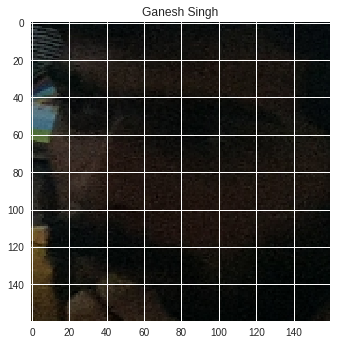

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


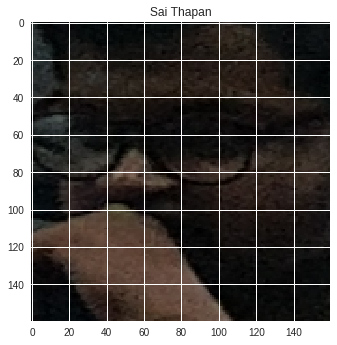

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


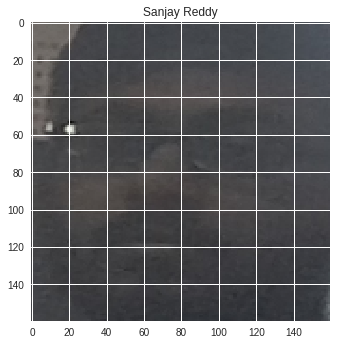

0 or 1 or 2   1
3
['Akash Katragadda', 'Akshay Raut', 'Ananya Anand', 'Anmol Bhutada', 'Chaitanya Chawla', 'Chaitanya Sai', 'Dhruv Parashar', 'Ganesh Singh', 'Harshit Buddhraja', 'Jonala Rahul', 'Kartik Mehta', 'Kundan Dewangan', 'Manish V', 'Manisha Baheti', 'Prateek Jha', 'Revanth Pendyala', 'Sai Thapan', 'Sanjay Reddy', 'Saurabh Yadav', 'Sheldon D Souza', 'Shiksha Swaraj', 'Shria D', 'Simran Tiwari', 'Sudarshan Raghavan', 'Taniya Mangwani', 'Uddalak Bhaduri', 'Ujjwal Karna', 'Veer Bains', 'Viharika Reddie', 'Vimal Patel', 'Vinay Singh', 'Vivek Singh']


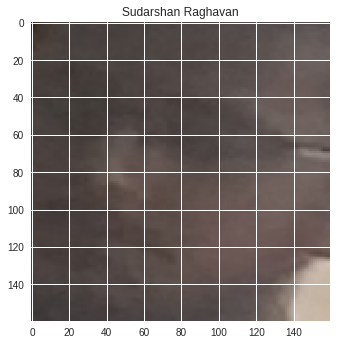

0 or 1 or 2   2


In [21]:
dir_path = '/content/drive/FaceRec/Ai Class/'
dir_path_store = '/content/drive/FaceRec/Classroom Photos/'
p=10
for i in os.listdir(dir_path):
  if '.jpg' in i:
    im = cv2.imread(dir_path+i)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(im)
    for face in dets:
        for i,f in enumerate(face['box']):
            if(f<0):
                face['box'][i] = 0


        [x,y,w,h] = face['box']
        left = x
        right = x+w
        top = y
        bottom = y+h
        cropped = im[y:y+h,x:x+w]
        cropped = cv2.resize(cropped,(160,160))
        pred = int (clf.predict(get_em(cropped))[0])
        print(names)
        plt.title(names[pred])
        plt.imshow(cropped)
        plt.show()
        ans = input('0 or 1 or 2   ')
        if(ans=='0'):
         
          a = input('Who is it?   ')
          if not os.path.exists(dir_path_store+a):
            os.makedirs(dir_path_store+a)
          # Store in the entered folders
          cropped = cv2.cvtColor(cropped,cv2.COLOR_RGB2BGR)
          if os.path.exists(dir_path_store+a+'/'+names[pred]+str(p)+'.jpg'):
#             print('')
            continue
          cv2.imwrite(dir_path_store+a+'/'+a+str(p)+'.jpg',cropped)
          # Train the classifier on the images
          clf,names = train('svm')
          
        elif (ans=='1'):
          # Store the image in predicted folder
          cropped = cv2.cvtColor(cropped,cv2.COLOR_RGB2BGR)
          cv2.imwrite(dir_path_store+names[pred]+'/'+names[pred]+str(p)+'.jpg',cropped)
          print(i)
        else:
          continue
        p+=1

    

In [0]:
1


In [0]:
# cascade_path = '/Users/tanmaypatil/Downloads/keras-facenet-master/model/cv2/haarcascade_frontalface_alt2.xml'
image_dir_basepath = 'images/'
names = ['U101115FCS164_train', 'U101115FCS110_train', 'U101115FCS182_train','U101115FCS087_train','U101115FCS094_train']
image_size = 160
crop_size = 32

In [0]:
i=0
x_train = []
y_train = []
for name in tqdm(names):
  i+=1
  for file in os.listdir(os.path.join(image_dir_basepath,name)):
    if file.endswith(".png"):
      im = imread(os.path.join(os.path.join(image_dir_basepath,name),file))
      im = resize(im, (image_size, image_size), mode='reflect')
      x_train.append(im)
      y_train.append(i)
#       plt.imshow(im)
#       plt.show()

In [0]:
for i,y in enumerate(y_train):
  y_train[i] = y-1

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
x_train,y_train = np.array(x_train),np.array(y_train)
x_train,y_train = unison_shuffled_copies(x_train,y_train)
y_train

In [0]:
!pwd

In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def calc_embs(aligned_images, margin=10, batch_size=1):
#     aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    aligned_images = prewhiten(aligned_images)
            
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def decrease_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
#     print(v)

    lim = 0 + value
    v[v < lim] = 0
    v[v >= lim] -= value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
def increase_hue(img,value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    h[h > lim] = 255
    h[h <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
def decrease_hue(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
#     print(v)

    lim = 0 + value
    h[h < lim] = 0
    h[h >= lim] -= value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def increase_saturation(img,value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    s[s > lim] = 255
    s[s <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
def decrease_saturation(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
#     print(v)

    lim = 0 + value
    s[s < lim] = 0
    s[s >= lim] -= value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [5]:
model_path = '/content/drive/FaceRec/model/keras/model/facenet_keras.h5'
model = load_model(model_path)

/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
direc = '/content/drive/FaceRec/one_shot/'

In [8]:
batch_size = 100
labels = []
embs_ = []
for k in (range(5)):
  file_path = direc + str(k+1)+ '.png'
  im = cv2.imread(file_path)
  print(file_path)
  im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
  im = cv2.resize(im,(160,160))
  images = []
  imagesa = []
  labels_ = []
  i = 0
  j = 0
  while(i<50):
      im1 = decrease_brightness(im,i)
      im2 = increase_brightness(im,i)
      while(j<50):
          images.append(np.array(decrease_saturation(im1,j)))
          images.append(np.array(increase_saturation(im1,j)))
          images.append(np.array(decrease_saturation(im2,j)))
          images.append(np.array(increase_saturation(im2,j)))

          j+=2
      imagesa.append(images)
      i+=5

  labels_ = np.zeros((1000,1)) + k
  labels.append(labels_)
  print(str(len(imagesa)*len(images)) + " created\n")
  print()
  face = np.concatenate(np.array(imagesa))
  print(face.shape)
  
  batch_size = 1000
  for start in tqdm(range(0, len(face), batch_size)):
      embs_.append(calc_embs(face[start:start+batch_size]))

  embs = np.concatenate(embs_)
  print(embs.shape)

  


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/FaceRec/one_shot/1.png
1000 created


(1000, 160, 160, 3)



100%|██████████| 1/1 [00:38<00:00, 38.56s/it]


(1000, 128)


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/FaceRec/one_shot/2.png
1000 created


(1000, 160, 160, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

(2000, 128)
/content/drive/FaceRec/one_shot/3.png
1000 created


(1000, 160, 160, 3)


100%|██████████| 1/1 [00:37<00:00, 37.82s/it]


(3000, 128)


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/FaceRec/one_shot/4.png
1000 created


(1000, 160, 160, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

(4000, 128)
/content/drive/FaceRec/one_shot/5.png
1000 created


(1000, 160, 160, 3)


100%|██████████| 1/1 [00:37<00:00, 37.83s/it]

(5000, 128)


In [0]:
np.save('embs_hsv_v1.npy',embs)

In [13]:
l = np.concatenate(labels)


((5000, 1), array([[0.],
        [0.],
        [0.],
        ...,
        [4.],
        [4.],
        [4.]]))

In [0]:
def train(embs,y):
    
    embs,y = unison_shuffled_copies(embs,y)
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(embs, y, test_size=0.1)

    clf = neighbors.KNeighborsClassifier(n_neighbors = 1001,weights='distance')
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print(accuracy)
    
    return clf

In [67]:
clf = train(embs,l)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


1.0


In [68]:
test_filepaths = []
image_dir_basepath = 'images/'
test_dirpath = os.path.join(image_dir_basepath, 'Test')
for f in os.listdir(test_dirpath):
    if f.endswith(".png") or f.endswith(".jpg"):
        test_filepaths.append(os.path.join(test_dirpath,f))
len(test_filepaths)
    

106

In [69]:
names = ['U101115FCS164_train', 'U101115FCS110_train', 'U101115FCS182_train','U101115FCS087_train','U101115FCS094_train']
for name in names:
    test_dirpath = os.path.join(image_dir_basepath, name)
    for f in os.listdir(test_dirpath):
        if f.endswith(".png") or f.endswith(".jpg"):
            test_filepaths.append(os.path.join(test_dirpath,f))
len(test_filepaths)


606

In [0]:
def calc_embs(aligned_images, margin=10, batch_size=1):
    
    aligned_images = prewhiten(np.array(aligned_images))
            
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs
def predict_k(filepath,clf):
  image_size = 160
  face = cv2.imread(filepath)
  face = cv2.resize(face,(image_size,image_size))
  face = cv2.cvtColor(face,cv2.COLOR_RGB2BGR)
  pred = clf.predict(calc_embs([face]))
#   print(pred)
  return pred[0]

In [71]:
predict_k(test_filepaths[0],clf)

1.0

In [72]:
names = ['U101115FCS087','U101115FCS110','U101115FCS164','U101115FCS182','U101115FCS094']
cor = 0
tot = len(test_filepaths)
for i in tqdm(range(tot)):
    if test_filepaths[i].endswith(".png") or test_filepaths[i].endswith(".jpg"):
        pred = int (predict_k(test_filepaths[i],clf))
#         plt.title(names[pred])
#         plt.imshow(imread(test_filepaths[i]))
#         plt.show()
        if(str(names[pred])==(test_filepaths[i].split("/")[-1].split("_")[0])):
            cor+=1
cor/tot

100%|██████████| 606/606 [00:37<00:00, 15.98it/s]


0.7739273927392739

In [80]:
embs[0] - embs[5],l[0],l[1],l[4]

(array([-1.68457627e-04,  6.70552254e-07,  6.31842762e-04, -1.13995373e-03,
         1.21422857e-03,  9.78458673e-04, -1.96349429e-04, -1.00538135e-04,
         1.08480453e-05, -6.90340996e-04,  1.33105367e-03,  3.92831862e-04,
        -7.38848001e-04, -1.06871128e-03,  7.80768692e-04,  1.61090493e-03,
         6.57819211e-04,  7.01189041e-04,  9.66619700e-05,  6.94748014e-04,
         1.35563314e-03, -5.19063324e-04,  6.25029206e-05,  1.30360946e-03,
        -1.41601264e-03, -6.82674348e-04,  4.38755378e-05, -9.80578363e-04,
        -5.25668263e-04, -3.93904746e-04,  4.14652750e-04,  1.96672976e-04,
        -6.11506402e-04,  9.68389213e-04,  6.72787428e-04,  3.89123335e-04,
        -1.78344548e-04, -4.34100628e-04,  2.44751573e-05,  5.30034304e-05,
        -4.77120280e-04, -9.08968970e-04,  6.71744347e-05,  5.25310636e-04,
        -3.97432595e-04, -9.42327082e-04,  3.25001776e-04, -7.80494418e-04,
         3.91684473e-04, -1.69694424e-04, -2.25439668e-04, -1.12733245e-03,
         6.2

In [0]:
def get_em(filepath):
  image_size = 160
  face = cv2.imread(filepath)
  face = cv2.resize(face,(image_size,image_size))
  face = cv2.cvtColor(face,cv2.COLOR_RGB2BGR)
  return calc_embs([face])
  


In [106]:
np.mean(get_em(test_filepaths[0]) - embs[1005])

0.008715423

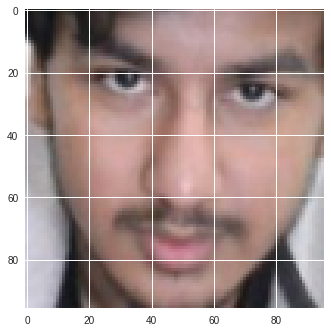

In [157]:
plt.imshow(imread(test_filepaths[5]))

In [0]:
for b in range(100):
  print(np.sum(np.square(get_em(test_filepaths[0]) - embs[b+2000])))

  


In [175]:
len(embs[0:1000]),len(embs[1000:2000]),len(embs[0:1000])
em1 = np.mean(embs[1:1000],axis = 0)
em2 = np.mean(embs[1000:2000],axis = 0)
em3 = np.mean(embs[2000:3000],axis = 0)
em4 = np.mean(embs[3000:4000],axis = 0)
em5 = np.mean(embs[4000:5000],axis = 0)
em5-em3,np.sum(np.square(em5 - em2))

(array([-0.01737272,  0.06501123, -0.02104323, -0.11625334,  0.0492731 ,
        -0.1138788 ,  0.01334975, -0.18434851, -0.0068888 , -0.02240541,
        -0.11860676, -0.03298385, -0.14891717,  0.01962923,  0.06578429,
         0.13419792, -0.20208149,  0.043244  , -0.11755659, -0.14938661,
        -0.03735013,  0.08666886,  0.06782916,  0.02245842,  0.02346206,
         0.05644917, -0.05909505, -0.04885796, -0.01380733,  0.09527945,
         0.07372278, -0.13251838, -0.04491533,  0.16689466, -0.00952584,
         0.00747613,  0.15909451, -0.14833686,  0.04871715,  0.07259026,
         0.0741768 , -0.1959062 ,  0.1193739 ,  0.03179878,  0.11875233,
        -0.15291317, -0.01615928,  0.03862903, -0.23851687,  0.0506889 ,
        -0.16713561, -0.18992828, -0.14454705,  0.19858792, -0.20486113,
        -0.02413004,  0.13537449, -0.0150871 ,  0.02360145, -0.08801934,
        -0.01833309, -0.16506694, -0.11473015, -0.07021004, -0.18151091,
        -0.0070054 , -0.10053831, -0.07196534, -0.2

In [0]:
# database = {'U101115FCS087':embs[0],
#            'U101115FCS110':embs[1000],
#            'U101115FCS164':embs[2000],
#            'U101115FCS182':embs[3000],
#            'U101115FCS094':embs[4000]}

database = [em1,em2,em3,em4,em5]

In [0]:

def predict_class(test_filepath,database):
  names = ['U101115FCS087','U101115FCS110','U101115FCS164','U101115FCS182','U101115FCS094']
  em = get_em(test_filepath)
  a = []
  for i in range(5):
    a.append(np.sum(np.square(em - database[i])))
  o = min(a)
  for i,j in enumerate(a):
    if j == o:
      return names[i]

In [178]:
predict_class(test_filepaths[5],database)

'U101115FCS182'

In [180]:
cor = 0
tot = len(test_filepaths)
for test in tqdm(test_filepaths):
  pred = predict_class(test,database)
#   plt.title(pred)
#   plt.imshow(imread(test))
#   plt.show()
  if(str(pred)==(test.split("/")[-1].split("_")[0])):
    cor+=1
cor/tot

100%|██████████| 606/606 [00:36<00:00, 16.51it/s]


0.7706270627062707

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import backend as K
from keras.layers import Dropout
from keras.utils import to_categorical
model = Sequential()
model.add(
        Conv2D(64, (5, 5),
        padding='same',
        input_shape=(160, 160, 3))
        )
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (1, 1),padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (1, 1),padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dense(16))
model.add(Activation('tanh'))
model.add(Dense(5))
model.add(Activation('softmax'))

In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y


In [0]:
from keras.utils import np_utils
x_train1 = prewhiten(x_train)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
y_train1 =np_utils.to_categorical(y_train)

In [0]:
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
# config = tf.ConfigProto(device_count = {'GPU': 0})
# sess = tf.Session(config=config)
model.fit(x_train1, y_train1, epochs=10, batch_size=1,validation_split=0.01,shuffle=True,verbose=1)

In [0]:
!cat /proc/cpuinfo

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
model.summary()

In [0]:
!conda install python=3.5

In [7]:
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:        10103820 kB
MemAvailable:   11195240 kB
Buffers:           30256 kB
Cached:          1541612 kB
SwapCached:            0 kB
Active:          1747048 kB
Inactive:        1190220 kB
Active(anon):    1530432 kB
Inactive(anon):   192976 kB
Active(file):     216616 kB
Inactive(file):   997244 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               248 kB
Writeback:             0 kB
AnonPages:       1365456 kB
Mapped:           499668 kB
Shmem:            357952 kB
Slab:             121444 kB
SReclaimable:      93004 kB
SUnreclaim:        28440 kB
KernelStack:        3392 kB
PageTables:         8540 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    2979708 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [0]:
dir_path = ''

In [0]:
embs = np.load('embs_hsv_v1.npy')

In [0]:
labels = []
for i in range(5):
  labels.append([[i]*16000])

In [0]:
labels = np.array(labels)
labels = np.concatenate(labels)
labels.shape
labels=labels.reshape((80000,1))

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
  
def train(embs,y):
  
    embs,y = unison_shuffled_copies(embs,y)
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(embs, y, test_size=0.1)

    clf = neighbors.KNeighborsClassifier(n_neighbors = int((len(y)/4)+10001),weights='distance')
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print(accuracy)
    
    return clf

In [0]:
clf = train(embs,labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
